# Data Cleaning and Transformation


**Importing Apache Spark Libraries.**

In [1]:
# Importing libraries 
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import col, sum, when, regexp_replace, round, udf

**Creating a new Spark Session.**

In [6]:
# Creating new SparkSession
spark = SparkSession.builder \
    .appName("MySparkApp") \
    .master("local[*]") \
    .config("spark.driver.host", "localhost") \
    .getOrCreate()

**Reading the Amazon-Products.csv in Hadoop.**

In [7]:
# Reading Amazon-Products.csv in Hadoop while applying options to read it correctly
df = spark.read.option("header", "true") \
               .option("inferSchema", "true") \
               .option("multiLine", "true") \
               .option("escape", "\"") \
               .option("quote", "\"") \
               .csv("hdfs://localhost:9000/user1/big_data_ca1/data/Amazon-Products.csv")

**Understanding the structure of the Spark Dataframe.**

In [8]:
# Reviewing the schema of the Spark Dataframe
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- image: string (nullable = true)
 |-- link: string (nullable = true)
 |-- ratings: string (nullable = true)
 |-- no_of_ratings: string (nullable = true)
 |-- discount_price: string (nullable = true)
 |-- actual_price: string (nullable = true)



In [9]:
# Dropping the columns that are not required for this task 
df = df.drop("_c0")
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- image: string (nullable = true)
 |-- link: string (nullable = true)
 |-- ratings: string (nullable = true)
 |-- no_of_ratings: string (nullable = true)
 |-- discount_price: string (nullable = true)
 |-- actual_price: string (nullable = true)



**Adding product_id column**

In [10]:
# Adding a new column to the dataframe named product_id while using the monotonically_increasing_id() function
df = df.withColumn("product_id", F.monotonically_increasing_id())

# Selecting the order of the columns of the dataframe
df = df.select(["product_id", "name", "main_category", "sub_category","image","link", "ratings", "no_of_ratings", "discount_price", "actual_price"])

# Print the the dataframe Schema
df.printSchema()

root
 |-- product_id: long (nullable = false)
 |-- name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- image: string (nullable = true)
 |-- link: string (nullable = true)
 |-- ratings: string (nullable = true)
 |-- no_of_ratings: string (nullable = true)
 |-- discount_price: string (nullable = true)
 |-- actual_price: string (nullable = true)



In [11]:
# Reviewing the rows of the Spark dataframe 
df.show()

+----------+--------------------+-------------+----------------+--------------------+--------------------+-------+-------------+--------------+------------+
|product_id|                name|main_category|    sub_category|               image|                link|ratings|no_of_ratings|discount_price|actual_price|
+----------+--------------------+-------------+----------------+--------------------+--------------------+-------+-------------+--------------+------------+
|         0|Lloyd 1.5 Ton 3 S...|   appliances|Air Conditioners|https://m.media-a...|https://www.amazo...|    4.2|        2,255|       ₹32,999|     ₹58,990|
|         1|LG 1.5 Ton 5 Star...|   appliances|Air Conditioners|https://m.media-a...|https://www.amazo...|    4.2|        2,948|       ₹46,490|     ₹75,990|
|         2|LG 1 Ton 4 Star A...|   appliances|Air Conditioners|https://m.media-a...|https://www.amazo...|    4.2|        1,206|       ₹34,490|     ₹61,990|
|         3|LG 1.5 Ton 3 Star...|   appliances|Air Conditi

25/04/21 19:58:17 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , name, main_category, sub_category, image, link, ratings, no_of_ratings, discount_price, actual_price
 Schema: _c0, name, main_category, sub_category, image, link, ratings, no_of_ratings, discount_price, actual_price
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user1/big_data_ca1/data/Amazon-Products.csv


In [12]:
# Get the number of rows
num_rows = df.count()
# Get the number of columns
num_columns = len(df.columns)

# Printing the shape (rows, columns)
print(f"Shape of the DataFrame: ({num_rows}, {num_columns})")


25/04/21 19:58:17 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , name, main_category, sub_category, image, link, ratings, no_of_ratings, discount_price, actual_price
 Schema: _c0, name, main_category, sub_category, image, link, ratings, no_of_ratings, discount_price, actual_price
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user1/big_data_ca1/data/Amazon-Products.csv
[Stage 5:>                                                          (0 + 1) / 1]

Shape of the DataFrame: (551585, 10)


**Checking the null values in the Spark Dataframe.**

In [13]:
# Counting the null or empty values per column
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

25/04/21 19:58:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , name, main_category, sub_category, image, link, ratings, no_of_ratings, discount_price, actual_price
 Schema: _c0, name, main_category, sub_category, image, link, ratings, no_of_ratings, discount_price, actual_price
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user1/big_data_ca1/data/Amazon-Products.csv
[Stage 8:>                                                          (0 + 1) / 1]

+----------+----+-------------+------------+-----+----+-------+-------------+--------------+------------+
|product_id|name|main_category|sub_category|image|link|ratings|no_of_ratings|discount_price|actual_price|
+----------+----+-------------+------------+-----+----+-------+-------------+--------------+------------+
|         0|   0|            0|           0|    0|   0| 175794|       175794|         61163|       17813|
+----------+----+-------------+------------+-----+----+-------+-------------+--------------+------------+



**Handling Null values in the Spark Dataframe.**

In [14]:
# Filtering out rows where both 'discount_price' and 'actual_price' are null.
df_clean = df.filter(~(col("discount_price").isNull() & col("actual_price").isNull()))

# Mathcing the discount_price column that is null to the actual_price column.
df_clean = df_clean.withColumn('discount_price', 
                               when(col('discount_price').isNull(), col('actual_price'))
                               .otherwise(col('discount_price')))

# Filling the null values for ratings, no_of_ratings, discount_price and actual_price to 0
df_clean = df_clean.fillna({"ratings": 0,"no_of_ratings": 0})

In [15]:
# Counting the null or empty values per column
df_clean.select([
    sum(when(col(column_name).isNull() | (col(column_name) == ""), 1).otherwise(0)).alias(column_name + "_nulls")
    for column_name in df.columns
]).show()

25/04/21 19:58:22 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , name, main_category, sub_category, image, link, ratings, no_of_ratings, discount_price, actual_price
 Schema: _c0, name, main_category, sub_category, image, link, ratings, no_of_ratings, discount_price, actual_price
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/user1/big_data_ca1/data/Amazon-Products.csv
[Stage 11:>                                                         (0 + 1) / 1]

+----------------+----------+-------------------+------------------+-----------+----------+-------------+-------------------+--------------------+------------------+
|product_id_nulls|name_nulls|main_category_nulls|sub_category_nulls|image_nulls|link_nulls|ratings_nulls|no_of_ratings_nulls|discount_price_nulls|actual_price_nulls|
+----------------+----------+-------------------+------------------+-----------+----------+-------------+-------------------+--------------------+------------------+
|               0|         0|                  0|                 0|          0|         0|            0|                  0|                   0|                 0|
+----------------+----------+-------------------+------------------+-----------+----------+-------------+-------------------+--------------------+------------------+



**Handling duplicate rows in the Spark Dataframe.**

In [16]:
# Removing the duplicate rows based on name from the Spark DataFrame 
df_clean = df_clean.dropDuplicates(["name"])


**Cleaning the ratings and no_of_rating columns.**

In [17]:
# Ensuring the rows where the 'ratings' column contains valid numbers (integers or decimals).
df_clean = df_clean.filter(F.col('ratings').rlike(r'^[0-9]*\.?[0-9]+$'))

# Ensuring ratings are between 0 and 5.0
df_clean = df_clean.filter((F.col('ratings') >= 0) & (F.col('ratings') <= 5.0))


In [18]:
# Removing commas from 'no_of_ratings'
df_clean = df_clean.withColumn("no_of_ratings", regexp_replace(col("no_of_ratings"), ",", ""))

# Ensuring the rows where the 'no_of_ratings' column contains valid numbers (integers).
df_clean = df_clean.filter(col("no_of_ratings").rlike("^[0-9]+$"))

**Converting currency from Indian Rupee to Euro for the actual_price and discount_price columns.**

In [19]:
# Removing ₹, commas and convert to double
df_converted = df_clean.withColumn(
    "actual_price",
    regexp_replace(col("actual_price"), "[₹,]", "").cast("double")  
)

# Converting INR to EUR (using conversion rate: 1 INR = 0.011 EUR)
conversion_rate = 0.011
df_converted = df_converted.withColumn(
    "actual_price",
    round(col("actual_price") * conversion_rate, 2)
)

In [20]:
# Removing ₹, commas and convert to double
df_converted = df_converted.withColumn(
    "discount_price",
    regexp_replace(col("discount_price"), "[₹,]", "").cast("double") 
)

# Converting INR to EUR (using conversion rate: 1 INR = 0.011 EUR)
conversion_rate = 0.011
df_converted = df_converted.withColumn(
    "discount_price",
    round(col("discount_price") * conversion_rate, 2) 
)

**Saving converted Spark Dataframe as a CSV file in Hadoop**

In [ ]:
df_converted.write \
  .option("header", "true") \
  .option("quoteAll", "true") \
  .option("escape", "\"") \
  .mode("overwrite")\
  .csv("hdfs://localhost:9000/user1/big_data_ca1/data/Amazon-Products-Cleaned.csv")

# Inserting CSV Data into HBase 

**Importing HappyBase Library to connect to HBase.**

In [21]:
import happybase

**Reading the Amazon-Products-Cleaned.csv in Hadoop**

In [22]:
# Reading Amazon-Products-Cleaned.csv in Hadoop while applying options to read it correctly
df = spark.read.option("header", "true") \
               .option("inferSchema", "true") \
               .option("multiLine", "true") \
               .option("escape", "\"") \
               .option("quote", "\"") \
               .csv("hdfs://localhost:9000/user1/big_data_ca1/data/Amazon-Products-Cleaned.csv")

**Reviewing the Schema of Amazon-Products-Cleaned.csv**

In [23]:
# Reviewing the schema of the Spark Dataframe
df.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- image: string (nullable = true)
 |-- link: string (nullable = true)
 |-- ratings: double (nullable = true)
 |-- no_of_ratings: integer (nullable = true)
 |-- discount_price: double (nullable = true)
 |-- actual_price: double (nullable = true)



In [24]:
df.show()

+----------+--------------------+-------------------+--------------------+--------------------+--------------------+-------+-------------+--------------+------------+
|product_id|                name|      main_category|        sub_category|               image|                link|ratings|no_of_ratings|discount_price|actual_price|
+----------+--------------------+-------------------+--------------------+--------------------+--------------------+-------+-------------+--------------+------------+
|    231435|"DN Enterprises" ...|        accessories| Handbags & Clutches|https://m.media-a...|https://www.amazo...|    3.4|           24|          3.84|       14.29|
|    268681|"GOMUKH” Gangajal...|    beauty & health|  Household Supplies|https://m.media-a...|https://www.amazo...|    4.8|            5|          3.62|        4.39|
|    365849|"Handicraft-Palac...|   women's clothing|Lingerie & Nightwear|https://m.media-a...|https://www.amazo...|    4.0|            3|          8.24|       10.99

**Connecting to Hbase**

In [25]:
# Connecting to HBase with the happybase library 
connection = happybase.Connection('localhost')
connection.open()

**Creating and adding data to the table.**

In [26]:
# Defining the column families 
column_families = {
    'Item_Info': dict(),
    'Ratings_Info': dict(),
    'Pricing_Info': dict(),
    'Recommendation_Info':dict(),
}

# Creating the table amazon_products if it doesn't exist
table_name = 'amazon_products'
if table_name not in connection.tables():
    connection.create_table(table_name, column_families)

# Getting the table amazon_products
table = connection.table(table_name)

# For loop to add the data from Amazon-Products-Cleaned.csv to the table amazon_products
for row in df.rdd.collect():
    # Using the product id as the row key
    row_key = str(row['product_id'])
    
    # Adding the data to the table
    table.put(row_key, {
        'Item_Info:name': row['name'],
        'Item_Info:main_category': row['main_category'],
        'Item_Info:sub_category': row['sub_category'],
        'Item_Info:image': row['image'], 
        'Item_Info:link': row['link'], 
        'Ratings_Info:ratings': str(row['ratings']),
        'Ratings_Info:no_of_ratings': str(row['no_of_ratings']),
        'Pricing_Info:discount_price': str(row['discount_price']),
        'Pricing_Info:actual_price': str(row['actual_price']),
        'Recommendation_Info:recommended_products': ''
    })


**Closing the connection**

In [27]:
connection.close()

# Retrieving Data from HBase to a Spark DataFrame

In [28]:
# Establish a connection to HBase
connection = happybase.Connection('localhost')
connection.open()

# Access the HBase table
table = connection.table('amazon_products')

# Scan the table and convert it into a list of dictionaries for DataFrame
rows = table.scan()
formatted_data = []

for row_key, data in rows:
    formatted_row = {
        "product_id": row_key.decode("utf-8"),
        "name": data.get(b'Item_Info:name', b'').decode("utf-8"),
        "main_category": data.get(b'Item_Info:main_category', b'').decode("utf-8"),
        "sub_category": data.get(b'Item_Info:sub_category', b'').decode("utf-8"),
        "ratings": data.get(b'Ratings_Info:ratings', b'').decode("utf-8"),
        "no_of_ratings": data.get(b'Ratings_Info:no_of_ratings', b'').decode("utf-8"),
        "discount_price": data.get(b'Pricing_Info:discount_price', b'').decode("utf-8"),
        "actual_price": data.get(b'Pricing_Info:actual_price', b'').decode("utf-8")
    }
    formatted_data.append(formatted_row)

# Convert the list to a Spark DataFrame
spark_df = spark.createDataFrame(formatted_data)

# Close the connection to HBase (after DataFrame creation)
connection.close()

In [29]:
# Selecting the order of the columns of the dataframe
spark_df = spark_df.select(["product_id", "name", "main_category", "sub_category", "ratings", "no_of_ratings", "discount_price", "actual_price"])

# Adjusting the columns to the correct object type
spark_df = spark_df.withColumn("product_id", col("product_id").cast(IntegerType())) \
                   .withColumn("ratings", col("ratings").cast(DoubleType())) \
                   .withColumn("no_of_ratings", col("no_of_ratings").cast(IntegerType())) \
                   .withColumn("discount_price", col("discount_price").cast(DoubleType())) \
                   .withColumn("actual_price", col("actual_price").cast(DoubleType()))

# Print the the dataframe Schema
spark_df.printSchema()

root
 |-- product_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- sub_category: string (nullable = true)
 |-- ratings: double (nullable = true)
 |-- no_of_ratings: integer (nullable = true)
 |-- discount_price: double (nullable = true)
 |-- actual_price: double (nullable = true)



# Apache Spark - Basic Analysis and Insights 

**Importing Libraries for visualisations**

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import subprocess

**Using the Spark Dataframe retieved from HBase**

In [31]:
# Using the Spark Dataframe retieved from HBase
df = spark_df

**Filtering dataframe for the top 5 for ratings >= 4.5 and number of ratings > 1000**

In [32]:
# Filtering dataframe for the top 5 for ratings >= 4.5 and number of ratings > 1000
df_top_5_product_review = df.filter((F.col("ratings") >= 4.5) & (F.col("no_of_ratings") > 1000)) \
  .orderBy(F.desc("ratings"), F.desc("no_of_ratings")) \
  .limit(5)

df_top_5_product_review.show()

25/04/21 20:02:00 WARN TaskSetManager: Stage 18 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.
[Stage 18:>                                                         (0 + 2) / 2]

+----------+--------------------+--------------------+-----------------+-------+-------------+--------------+------------+
|product_id|                name|       main_category|     sub_category|ratings|no_of_ratings|discount_price|actual_price|
+----------+--------------------+--------------------+-----------------+-------+-------------+--------------+------------+
|    127564|Pampers Swaddlers...|toys & baby products|          Diapers|    4.9|        26160|        143.09|      204.48|
|    396433|Medela Breastmilk...|toys & baby products|Nursing & Feeding|    4.9|         7404|         52.95|       133.1|
|    128043|Pampers Diapers S...|toys & baby products|          Diapers|    4.9|         6553|        220.71|       607.2|
|    338984|DOWAN multi color...|      home & kitchen| Kitchen & Dining|    4.9|         5485|          4.94|       54.99|
|      3434|Scrub Daddy Insta...|          appliances|   All Appliances|    4.9|         2285|         15.39|        38.5|
+----------+----

25/04/21 20:02:01 WARN TaskSetManager: Stage 19 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.


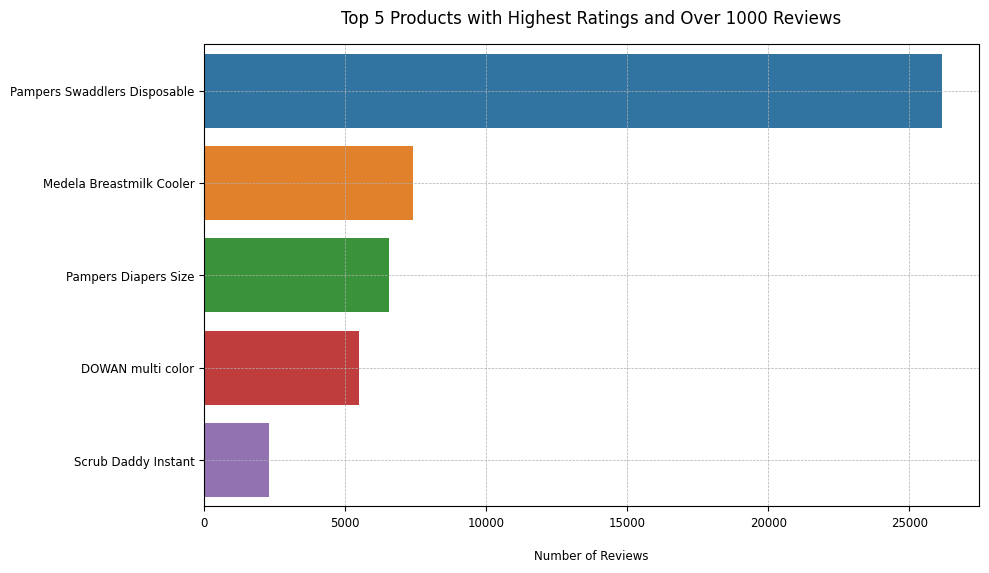

In [33]:
# Changing the Apache Spark Dataframe to Panda Dataframe
df_top_5_product_review_pd = df_top_5_product_review.toPandas()

# Function to take only the first 3 words from the product name
def first_three_words(name):
    words = name.split()
    return ' '.join(words[:3])

# Adjusting the product name for readability 
df_top_5_product_review_pd['name'] = df_top_5_product_review_pd['name'].apply(first_three_words)

# Setting the figure size
plt.figure(figsize=(10, 6))

# Creating the bar chart using seaborn
sns.barplot(
    x="no_of_ratings",
    y="name",
    data=df_top_5_product_review_pd,
    hue="name",
    palette="tab10"
)

# Styling the plot
plt.grid(True, which='major', linestyle='--', linewidth=0.5, zorder=0)
plt.title("Top 5 Products with Highest Ratings and Over 1000 Reviews", loc="center", pad=15, fontsize=12)
plt.xlabel("Number of Reviews", loc="center", labelpad=15, fontsize=8.5)
plt.ylabel("")  
plt.tick_params(axis='both', labelsize=8.5)

# Saving the plot as an image and uploading it to Hadoop
plt.savefig("top_5_products_based_on_highest_rating.png", dpi=300, bbox_inches='tight')
subprocess.run(["hdfs", "dfs", "-put", "-f", "top_5_products_based_on_highest_rating.png", "/user1/big_data_ca1/images/"])

# Showing the plot
plt.show()


**Filtering dataframe for the bottom 5 for ratings >= 1 and number of ratings > 1000**

In [34]:
# Filtering dataframe for the bottom 5 for ratings >= 1 and number of ratings > 1000
df_bottom_5_products_review = df.filter((F.col("ratings") >= 1) & (F.col("no_of_ratings") > 1000)) \
  .orderBy(F.asc("ratings"), F.asc("no_of_ratings")) \
  .limit(5)

df_bottom_5_products_review.show()

25/04/21 20:02:03 WARN TaskSetManager: Stage 20 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+-------------------+------------------+-------+-------------+--------------+------------+
|product_id|                name|      main_category|      sub_category|ratings|no_of_ratings|discount_price|actual_price|
+----------+--------------------+-------------------+------------------+-------+-------------+--------------+------------+
|     13743|DEVCOMM Phone Blu...|tv, audio & cameras|   All Electronics|    2.5|         1225|          1.54|         3.3|
|      1808|Prestige Roti Mak...|         appliances|    All Appliances|    2.6|         1411|         31.61|       37.35|
|     87534|TYING Men's Trend...|        men's shoes|      Casual Shoes|    2.7|         1942|          3.29|       10.98|
|     24226|Kuber Industries ...|     home & kitchen|All Home & Kitchen|    2.7|         1977|          3.83|        5.49|
|    371671|Generic Silica Ge...|    beauty & health|           Make-up|    2.8|         1645|          1.74|        3.29|
+----------+----

25/04/21 20:02:08 WARN TaskSetManager: Stage 21 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.


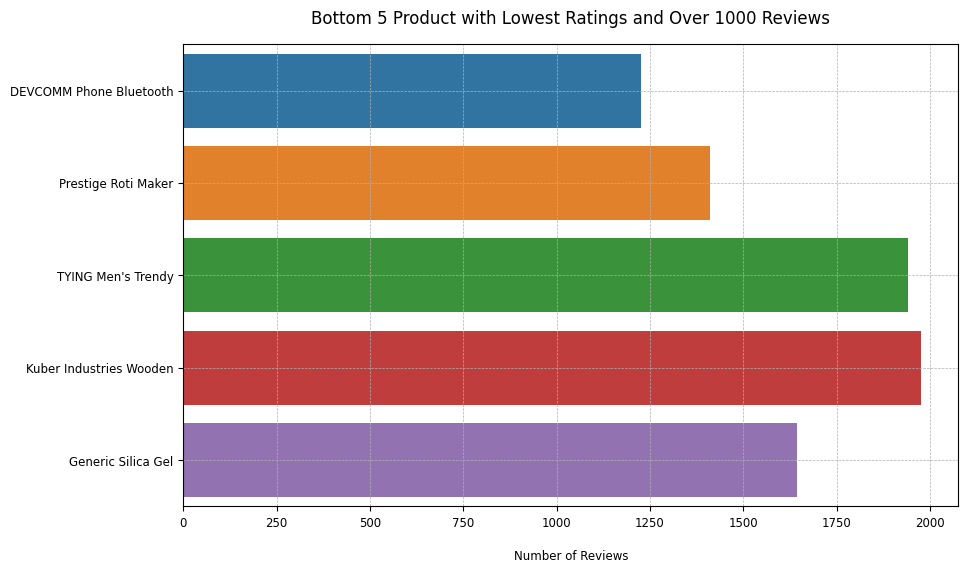

In [35]:
# Changing the Apache Spark Dataframe to Panda Dataframe
df_bottom_5_products_review_pd = df_bottom_5_products_review.toPandas()
# Adjusting the product name for readability 
df_bottom_5_products_review_pd['name'] = df_bottom_5_products_review_pd['name'].apply(first_three_words)

# Setting the figure size
plt.figure(figsize=(10, 6))

# Creating the bar chart using seaborn
sns.barplot(
    x="no_of_ratings",
    y="name",
    data=df_bottom_5_products_review_pd,
    hue="name",
    palette="tab10"
)

# Styling the plot
plt.grid(True, which='major', linestyle='--', linewidth=0.5, zorder=0)
plt.title("Bottom 5 Product with Lowest Ratings and Over 1000 Reviews", loc="center", pad=15, fontsize=12)
plt.xlabel("Number of Reviews", loc="center", labelpad=15, fontsize=8.5)
plt.ylabel("")  
plt.tick_params(axis='both', labelsize=8.5)

# Saving the plot as an image and uploading it to Hadoop
plt.savefig("bottom_5_products_based_on_lowest_rating.png", dpi=300, bbox_inches='tight')
subprocess.run(["hdfs", "dfs", "-put", "-f", "bottom_5_products_based_on_lowest_rating.png", "/user1/big_data_ca1/images/"])

# Showing the plot
plt.show()

**Grouping by 'main_category' and calculate summary statistics for prices**

In [36]:
# Grouping by 'main_category' and calculate summary statistics for prices
df_price_stats = df.groupBy("main_category").agg(
    F.min("actual_price").alias("min_actual_price"),
    F.max("actual_price").alias("max_actual_price"),
    F.percentile_approx("actual_price", 0.5).alias("median_actual_price"),
    F.min("discount_price").alias("min_discount_price"),
    F.max("discount_price").alias("max_discount_price"),
    F.percentile_approx("discount_price", 0.5).alias("median_discount_price")
).orderBy(col("median_actual_price").desc())

# Show dataframe
df_price_stats.show(5)

25/04/21 20:02:09 WARN TaskSetManager: Stage 22 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.
[Stage 22:>                                                         (0 + 2) / 2]

+-------------------+----------------+----------------+-------------------+------------------+------------------+---------------------+
|      main_category|min_actual_price|max_actual_price|median_actual_price|min_discount_price|max_discount_price|median_discount_price|
+-------------------+----------------+----------------+-------------------+------------------+------------------+---------------------+
|home, kitchen, pets|            22.0|           87.56|              37.51|              19.8|             55.44|                26.39|
|        men's shoes|            0.43|          734.57|              27.49|              0.27|            733.14|                15.39|
|         appliances|            0.65|          6600.0|               23.1|              0.22|            2530.0|                14.29|
|     bags & luggage|            0.88|         2139.49|              21.99|              0.65|            1540.0|                10.31|
|             stores|             0.0|          

25/04/21 20:02:15 WARN TaskSetManager: Stage 25 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

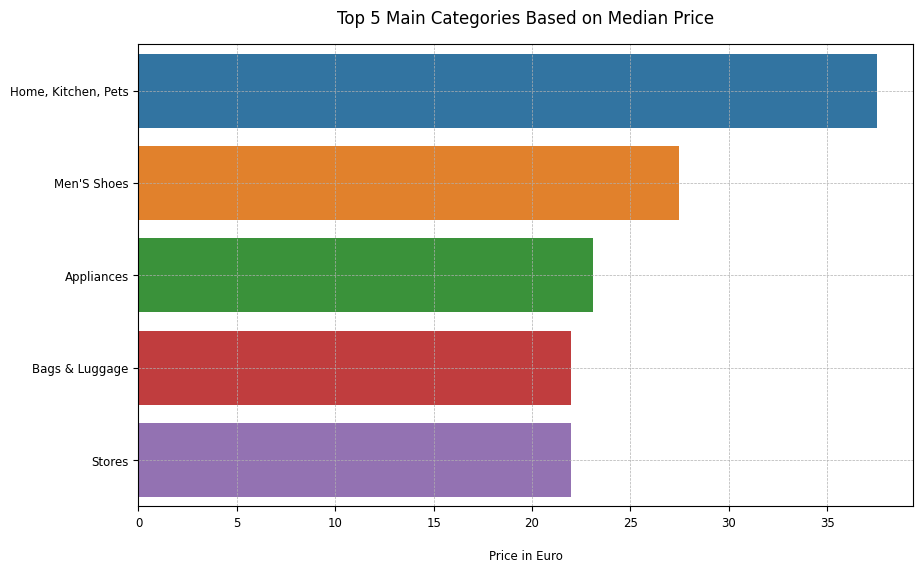

In [37]:
# Changing the Apache Spark Dataframe to Panda Dataframe
df_price_stats_pd = df_price_stats.toPandas()

# Retieving the top 5 main category
df_top_5_main_category = df_price_stats_pd.head(5)
# Applying the main category as a title for readability 
df_top_5_main_category.loc[:, "main_category"] = df_top_5_main_category["main_category"].apply(str.title)

# Setting the figure size
plt.figure(figsize=(10, 6))

# Creating the bar chart using seaborn
sns.barplot(
    x="median_actual_price",
    y="main_category",
    data=df_top_5_main_category,
    hue="main_category",
    palette="tab10"
)

# Styling the plot
plt.grid(True, which='major', linestyle='--', linewidth=0.5, zorder=0)
plt.title("Top 5 Main Categories Based on Median Price", loc="center", pad=15, fontsize=12)
plt.xlabel("Price in Euro", loc="center", labelpad=15, fontsize=8.5)
plt.ylabel("")  
plt.tick_params(axis='both', labelsize=8.5)

# Saving the plot as an image and uploading it to Hadoop
plt.savefig("top_5_main_categories_based_on_median_price.png", dpi=300, bbox_inches='tight')
subprocess.run(["hdfs", "dfs", "-put", "-f", "top_5_main_categories_based_on_median_price.png", "/user1/big_data_ca1/images/"])

# Showing the plot
plt.show()


**Calculating the total discount loss based on actual price - discount price**

In [38]:
# Calculating the total discount loss based on actual price - discount price
total_discount_loss = df.withColumn("discount_loss", F.col("actual_price") - F.col("discount_price")) \
                      .agg(
                          F.format_number(F.sum("actual_price"), 2).alias("total_actual_price"),
                          F.format_number(F.sum("discount_loss"), 2).alias("total_discount_loss")
                      ) 

total_discount_loss.show()

25/04/21 20:02:35 WARN TaskSetManager: Stage 33 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.


+------------------+-------------------+
|total_actual_price|total_discount_loss|
+------------------+-------------------+
|    125,611,499.88|     115,326,080.00|
+------------------+-------------------+



25/04/21 20:02:40 WARN TaskSetManager: Stage 36 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.


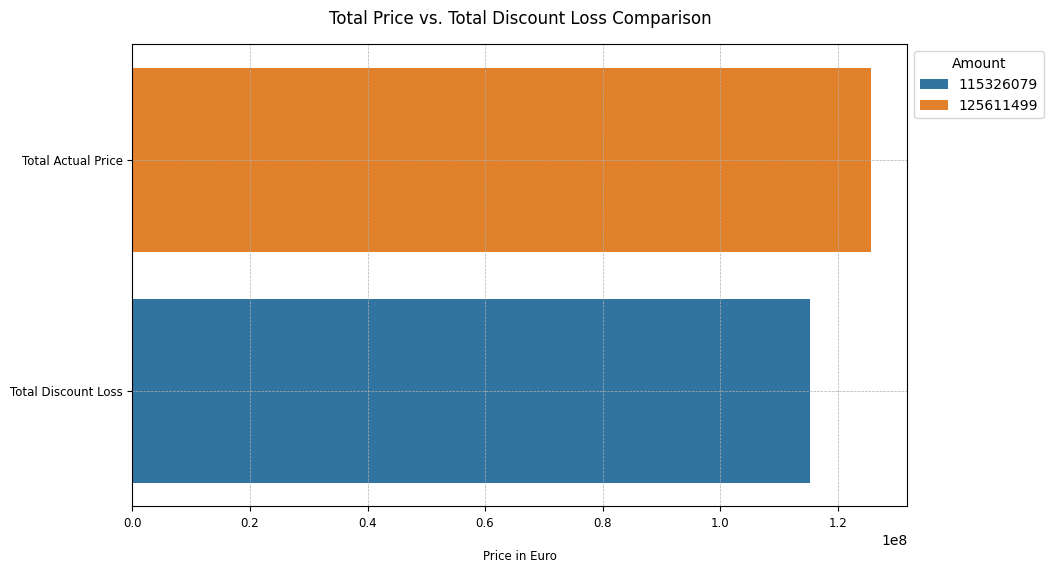

In [39]:
# Calculating the total discount loss based on actual price - discount price (without format_number)
total_discount_loss = df.withColumn("discount_loss", F.col("actual_price") - F.col("discount_price")) \
                      .agg(
                          F.sum("actual_price").alias("total_actual_price"),
                          F.sum("discount_loss").alias("total_discount_loss")
                      ) 

# Changing the Apache Spark Dataframe to Panda Dataframe
total_discount_loss_pd = total_discount_loss.toPandas()  

# Reshape the data for calculation and amount
total_discount_loss_reshape_sorted = pd.melt(total_discount_loss_pd, var_name="calculation", value_name="amount").sort_values(by="amount", ascending=False)

# Converting the amount value as an integer for readability 
total_discount_loss_reshape_sorted['amount'] = total_discount_loss_reshape_sorted['amount'].astype(int)
# Applying the caculation values as a title and removing "_" for readability 
total_discount_loss_reshape_sorted['calculation'] = total_discount_loss_reshape_sorted['calculation'].str.replace('_', ' ').str.title()

# Setting the figure size
plt.figure(figsize=(10, 6))

# Creating the bar chart using seaborn
sns.barplot(
    x="amount",
    y="calculation",
    data=total_discount_loss_reshape_sorted,
    hue="amount",
    palette="tab10"
)

# Styling the plot
plt.grid(True, which='major', linestyle='--', linewidth=0.5, zorder=0)
plt.title("Total Price vs. Total Discount Loss Comparison", loc="center", pad=15, fontsize=12)
plt.xlabel("Price in Euro", loc="center", labelpad=15, fontsize=8.5)
plt.ylabel("")  
plt.tick_params(axis='both', labelsize=8.5)

# Added a legend with title and move it outside the plot
plt.legend(title='Amount', bbox_to_anchor=(1,1), loc='upper left')

# Saving the plot as an image and uploading it to Hadoop
plt.savefig("total_price_vs_total_discount_loss.png", dpi=300, bbox_inches='tight')
subprocess.run(["hdfs", "dfs", "-put", "-f", "total_price_vs_total_discount_loss.png", "/user1/big_data_ca1/images/"])

# Showing the plot
plt.show()

**Grouping by 'main_category' and calculate average rating and total number of ratings**

In [40]:
# Grouping by 'main_category' and calculate average rating and total number of ratings
df_rating = df.groupBy("main_category") \
  .agg(
      F.round(F.avg("ratings"), 1).alias("average_rating"),
      F.sum("no_of_ratings").alias("total_number_ratings")
  ) \
  .orderBy(F.col("average_rating").desc()) \

df_rating.show()

25/04/21 20:03:29 WARN TaskSetManager: Stage 39 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------+--------------------+
|       main_category|average_rating|total_number_ratings|
+--------------------+--------------+--------------------+
|grocery & gourmet...|           3.7|             1571199|
|      home & kitchen|           3.6|             7356136|
|        pet supplies|           3.6|              894761|
|toys & baby products|           3.5|            12402530|
|              stores|           3.4|            11364674|
|               music|           3.2|              279078|
|          appliances|           3.1|             9313000|
|     beauty & health|           3.1|             9140047|
|    women's clothing|           3.0|             7050504|
|     car & motorbike|           3.0|             1412426|
| tv, audio & cameras|           2.7|           105574289|
| industrial supplies|           2.7|              826138|
|    sports & fitness|           2.7|             2280584|
|         accessories|           2.5|             796912

25/04/21 20:03:31 WARN TaskSetManager: Stage 42 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

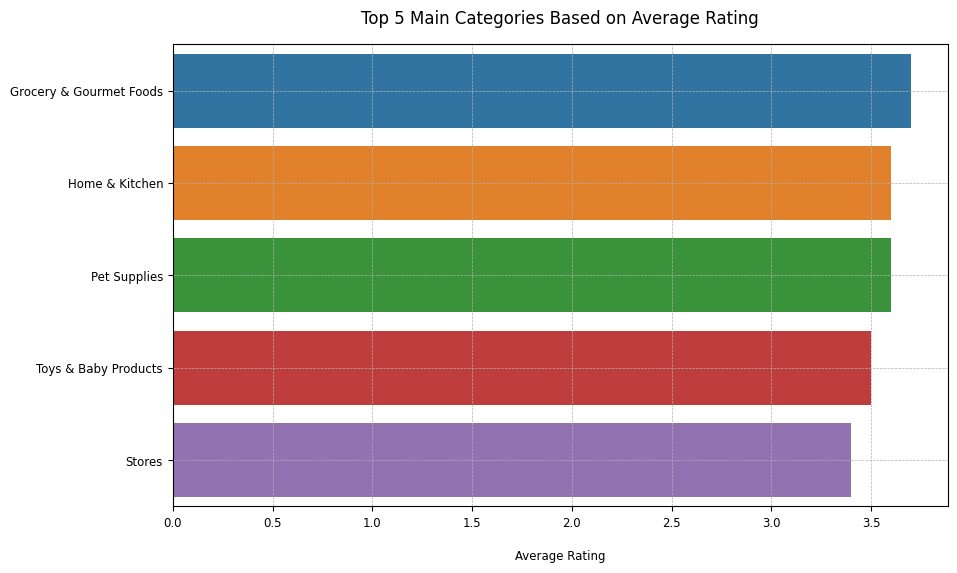

In [41]:
# Changing the Apache Spark Dataframe to Panda Dataframe
df_rating_pd = df_rating.toPandas()

# Retieving the top 5 main category
df_rating_top_5_main_category = df_rating_pd.head(5)

# Applying the main category as a title for readability 
df_rating_top_5_main_category.loc[:, "main_category"] = df_rating_top_5_main_category["main_category"].apply(str.title)

# Setting the figure size
plt.figure(figsize=(10, 6))

# Creating the bar chart using seaborn
sns.barplot(
    x="average_rating",
    y="main_category",
    data=df_rating_top_5_main_category,
    hue="main_category",
    palette="tab10"
)

# Styling the plot
plt.grid(True, which='major', linestyle='--', linewidth=0.5, zorder=0)
plt.title("Top 5 Main Categories Based on Average Rating", loc="center", pad=15, fontsize=12)
plt.xlabel("Average Rating", loc="center", labelpad=15, fontsize=8.5)
plt.ylabel("")  
plt.tick_params(axis='both', labelsize=8.5)

# Saving the plot as an image and uploading it to Hadoop
plt.savefig("top_5_main_categories_based_on_average_rating.png", dpi=300, bbox_inches='tight')
subprocess.run(["hdfs", "dfs", "-put", "-f", "top_5_main_categories_based_on_average_rating.png", "/user1/big_data_ca1/images/"])

# Showing the plot
plt.show()

# Apache Spark - Content-Based Recommendation

**Importing libraries for content-based recommendation**

In [42]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
import json

**Using the Spark Dataframe retieved from HBase**

In [43]:
# Using the Spark Dataframe retieved from HBase
df = spark_df

**Transforming DataFrame into Numeric Features**

In [44]:
# Indexing the categorical features ["main_category", "sub_category"]
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep") 
    for col in ["main_category", "sub_category"]
]

# Encoding the categorical features ["main_category", "sub_category"]
encoders = [
    OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") 
    for col in ["main_category", "sub_category"]
]

# Assembling all numeric features into a single vector named "features"
assembler = VectorAssembler(
    inputCols=["main_category_vec", "sub_category_vec", 
               "ratings", "no_of_ratings", "discount_price", "actual_price"],
    outputCol="features"
)

# Creating a Spark Pipeline that combines all stages (indexers, encoders, and the assembler)
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fitting the pipeline to the DataFrame 
model = pipeline.fit(df)

# Applying the fitted pipeline model to the DataFrame to transform i
df_features = model.transform(df)

25/04/21 20:03:41 WARN TaskSetManager: Stage 50 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.
25/04/21 20:03:42 WARN TaskSetManager: Stage 53 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

**Function to calculate similar recommended products**

In [46]:
def recommend_similar_products(product_id, top_n):
    
    # Display dataframe row for the specified product ID
    print(f"Product ID {product_id} information:")
    df.filter(df['product_id'] == product_id).show()
    
    # Get the row for the specified product ID based on df_features
    product_row = df_features.filter(col("product_id") == product_id).select("product_id", "features").first()

    # Get the feature vector for the input product
    product_vector = product_row['features']

    # Select product IDs and features (excluding the reference product itself)
    product_features = df_features.filter(col("product_id") != product_id).select("product_id", "features")

    # Function to compute cosine similarity 
    def cosine_similarity_udf(vec1, vec2):
        dot_product = float(vec1.dot(vec2))
        norm1 = float(vec1.norm(2))
        norm2 = float(vec2.norm(2))
        return dot_product / (norm1 * norm2)

    # Register the UDF for cosine similarity
    cosine_similarity = F.udf(lambda x: cosine_similarity_udf(x, product_vector), DoubleType())

    # Apply the cosine similarity calculation for each product in the DataFrame
    product_features = product_features.withColumn(
        "cosine_similarity_score", cosine_similarity(col("features"))
    )

    # Get the top_n most similar products by ordering by cosine similarity score
    similar_df = product_features.orderBy(col("cosine_similarity_score").desc()).limit(top_n)
    
    # Collect recommended product IDs
    recommended_product_ids = [row['product_id'] for row in similar_df.select('product_id').collect()]
    
    # Filtering dataframe based on recommended product IDs
    recommended_df = df.filter(df['product_id'].isin(recommended_product_ids))

    # Show the filtered rows of recommended products
    print(f"\nTop {top_n} recommended products based on Product ID {product_id}:")
    recommended_df.show()

    # Show the filtered rows of the top N recommended products with their cosine similarity scores
    print("Recommended Product IDs with Similarity Scores")
    similar_df.select("product_id", "cosine_similarity_score").show()

    # Collect recommended product IDs and cosine similarity score
    recommended_product_data = [(row['product_id'], row['cosine_similarity_score']) for row in similar_df.collect()]
    
    # Store recommendations in the 'Recommendation_Info:recommended_products' column as JSON
    recommendation_data = {
        'Recommendation_Info:recommended_products': json.dumps(recommended_product_data).encode()
    }

    return recommendation_data

**Function to save recommendation data to HBase**

In [47]:
def save_recommendations_to_hbase(product_id, recommendation_data):
    # Establish a connection to HBase
    connection = happybase.Connection('localhost')
    connection.open()
    
    # Access the HBase table
    table = connection.table('amazon_products')
    
    # Update the table with the recommended products for the product_id
    row_key = str(product_id)
    table.put(row_key, recommendation_data)

    # Print out the following if it has been successful 
    print(f"Updated HBase for Product ID {product_id} with recommendations.")
    print(recommendation_data)
        
    # Closing connection to HBase
    connection.close()

**Executing functions to find recommended products and storing it on HBase**

In [48]:
# Product ID as a variable for the functions
product_id = 123456  

# Get recommendations for the product_id
recommendation_data = recommend_similar_products(product_id, 5)

# Save the recommendations to HBase
save_recommendations_to_hbase(product_id, recommendation_data)


Product ID 123456 information:


25/04/21 20:05:36 WARN TaskSetManager: Stage 58 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.
25/04/21 20:05:37 WARN TaskSetManager: Stage 59 contains a task of very large size (28383 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+--------------------+--------------------+-------+-------------+--------------+------------+
|product_id|                name|       main_category|        sub_category|ratings|no_of_ratings|discount_price|actual_price|
+----------+--------------------+--------------------+--------------------+-------+-------------+--------------+------------+
|    123456|Society Premium L...|grocery & gourmet...|Coffee, Tea & Bev...|    4.3|          896|          6.36|        6.49|
+----------+--------------------+--------------------+--------------------+-------+-------------+--------------+------------+



25/04/21 20:05:37 WARN TaskSetManager: Stage 60 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.
25/04/21 20:05:41 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 60 (TID 56): Attempting to kill Python Worker
25/04/21 20:05:41 WARN TaskSetManager: Stage 61 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.
25/04/21 20:05:52 WARN TaskSetManager: Stage 62 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.



Top 5 recommended products based on Product ID 123456:


25/04/21 20:05:52 WARN TaskSetManager: Stage 63 contains a task of very large size (28383 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+--------------------+--------------------+-------+-------------+--------------+------------+
|product_id|                name|       main_category|        sub_category|ratings|no_of_ratings|discount_price|actual_price|
+----------+--------------------+--------------------+--------------------+-------+-------------+--------------+------------+
|    123638|The Indian Chai -...|grocery & gourmet...|Coffee, Tea & Bev...|    4.1|          632|          4.35|        4.39|
|    123686|Organic Turmeric ...|grocery & gourmet...|Coffee, Tea & Bev...|    4.4|         1192|          7.47|        8.79|
|    123793|Krishna's Papaya ...|grocery & gourmet...|Coffee, Tea & Bev...|    4.1|          860|          5.39|         5.5|
|     22602|Happilo Premium C...|grocery & gourmet...|All Grocery & Gou...|    4.2|         1050|          7.17|        8.69|
|     22928|Beyond Snáck Natu...|grocery & gourmet...|All Grocery & Gou...|    3.8|          794|          5.05|      

25/04/21 20:05:53 WARN TaskSetManager: Stage 64 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.
25/04/21 20:06:02 WARN TaskSetManager: Stage 65 contains a task of very large size (29507 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----------------------+
|product_id|cosine_similarity_score|
+----------+-----------------------+
|    123793|     0.9999992928584063|
|    123686|     0.9999989555123614|
|    123638|     0.9999982905281469|
|     22928|      0.999998273338888|
|     22602|     0.9999980214739426|
+----------+-----------------------+



[Stage 65:=============================>                            (1 + 1) / 2]

Updated HBase for Product ID 123456 with recommendations.
{'Recommendation_Info:recommended_products': b'[[123793, 0.9999992928584063], [123686, 0.9999989555123614], [123638, 0.9999982905281469], [22928, 0.999998273338888], [22602, 0.9999980214739426]]'}
